# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [38]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
from util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.7321094609157
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.954586390884565
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.35417699419094
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.779125916898224
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.0920445

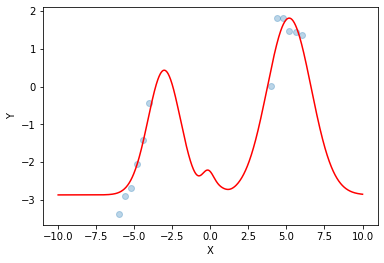

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');


## Random

In [4]:
w0 = my_nn.weights

In [5]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture,Sigma_Y=0.25)
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
# raw weight: 
# P=np.eye(P.shape[0])
# w=np.zeros_like(w)

In [6]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [9]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

In [10]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [11]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 100.0 with step size 0.0025000000000000005
HMC 600: accept rate of 99.83333333333333 with step size 0.004000000000000001
HMC 800: accept rate of 99.625 with step size 0.005494533605113767
HMC 1000: accept rate of 99.1 with step size 0.006937866409072428
HMC 1200: accept rate of 99.25 with step size 0.008437866409072427
HMC 1400: accept rate of 99.07142857142858 with step size 0.009937866409072427
HMC 1600: accept rate of 98.625 with step size 0.010931689122023856
HMC 1800: accept rate of 98.27777777777777 with step size 0.012306834086118924
HMC 2000: accept rate of 97.35000000000001 with step size 0.013235364678952338
HMC 2200: accept rate of 96.72727272727273 with step size 0.014438072173975481
HMC 2400: accept rate of 96.5 with step size 0.01593807217397548
HMC 2600: accept rate of 95.53846153846153 with step size 0.017438072173975482
HMC 2800: accept rate of 94.32142857142857 with step size 0.0189380721739754

In [12]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 6.42 min


In [13]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))
# x_test = np.linspace(-8, 8, 100)
# y_test = np.reshape(
#     [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
#     (n_sample, -1)) \
#          + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

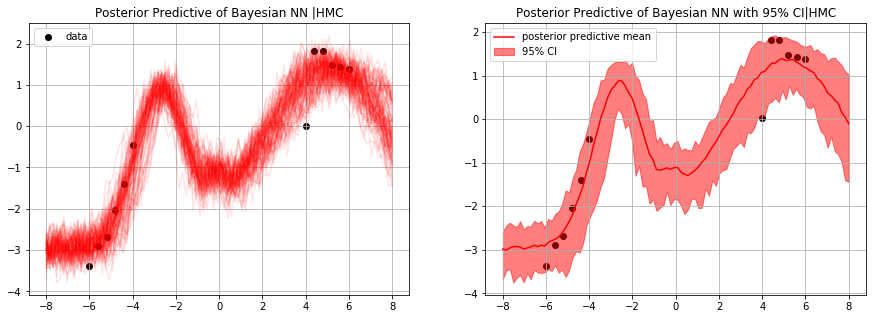

In [14]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

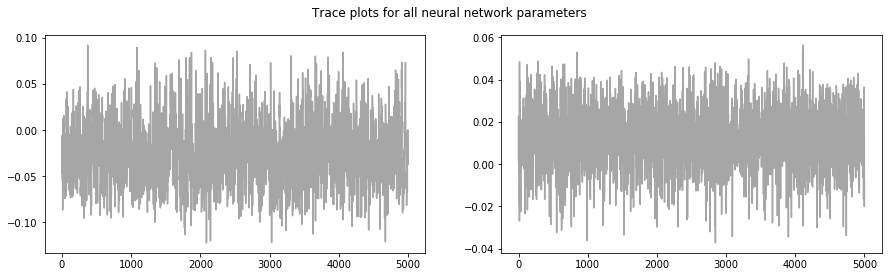

In [15]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

## PCA

In [16]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture,Sigma_Y=0.25)
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
# raw weight: 
# P=np.eye(P.shape[0])
# w=np.zeros_like(w)

In [28]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 200000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [29]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

In [30]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [31]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.05
HMC 400: accept rate of 100.0 with step size 0.051500000000000004
HMC 600: accept rate of 100.0 with step size 0.053000000000000005
HMC 800: accept rate of 100.0 with step size 0.05450000000000001
HMC 1000: accept rate of 100.0 with step size 0.05600000000000001
HMC 1200: accept rate of 99.91666666666667 with step size 0.05750000000000001
HMC 1400: accept rate of 99.92857142857143 with step size 0.05897606659958734
HMC 1600: accept rate of 99.8125 with step size 0.06047255398511146
HMC 1800: accept rate of 99.72222222222223 with step size 0.0619596233131773
HMC 2000: accept rate of 99.55000000000001 with step size 0.0634596233131773
HMC 2200: accept rate of 99.59090909090908 with step size 0.0649596233131773
HMC 2400: accept rate of 99.5 with step size 0.06639458171418774
HMC 2600: accept rate of 99.42307692307692 with step size 0.06789458171418775
HMC 2800: accept rate of 99.35714285714286 with step size 0.06928484512815469
HMC 3000: a

HMC 22000: accept rate of 92.91818181818182 with step size 0.1816128637054811
HMC 22200: accept rate of 92.88288288288288 with step size 0.18282787566638986
HMC 22400: accept rate of 92.8125 with step size 0.18429039473185696
HMC 22600: accept rate of 92.61504424778761 with step size 0.18079047846978283
HMC 22800: accept rate of 92.50438596491229 with step size 0.1818881445399619
HMC 23000: accept rate of 92.42608695652173 with step size 0.1832683473315631
HMC 23200: accept rate of 92.32758620689656 with step size 0.18162177942007598
HMC 23400: accept rate of 92.25641025641026 with step size 0.18183246550523474
HMC 23600: accept rate of 92.19915254237289 with step size 0.18333013248068142
HMC 23800: accept rate of 92.08403361344538 with step size 0.18483013248068142
HMC 24000: accept rate of 92.0125 with step size 0.186323406103363
HMC 24200: accept rate of 91.91735537190083 with step size 0.18290545617364756
HMC 24400: accept rate of 91.86065573770492 with step size 0.1844054561736475

HMC 6400: accept rate of 72.40625
HMC 6600: accept rate of 72.24242424242425
HMC 6800: accept rate of 72.22058823529412
HMC 7000: accept rate of 72.47142857142858
HMC 7200: accept rate of 72.56944444444444
HMC 7400: accept rate of 72.58108108108108
HMC 7600: accept rate of 72.44736842105263
HMC 7800: accept rate of 72.46153846153847
HMC 8000: accept rate of 72.4875
HMC 8200: accept rate of 72.36585365853658
HMC 8400: accept rate of 72.25
HMC 8600: accept rate of 72.15116279069767
HMC 8800: accept rate of 72.23863636363636
HMC 9000: accept rate of 72.23333333333333
HMC 9200: accept rate of 72.17391304347827
HMC 9400: accept rate of 72.1063829787234
HMC 9600: accept rate of 72.125
HMC 9800: accept rate of 72.1938775510204
HMC 10000: accept rate of 72.16
HMC 10200: accept rate of 72.31372549019608
HMC 10400: accept rate of 72.3173076923077
HMC 10600: accept rate of 72.25471698113208
HMC 10800: accept rate of 72.26851851851852
HMC 11000: accept rate of 72.3
HMC 11200: accept rate of 72.491

HMC 44800: accept rate of 72.94642857142857
HMC 45000: accept rate of 72.94444444444444
HMC 45200: accept rate of 72.93141592920354
HMC 45400: accept rate of 72.91850220264317
HMC 45600: accept rate of 72.90131578947368
HMC 45800: accept rate of 72.89737991266375
HMC 46000: accept rate of 72.86521739130434
HMC 46200: accept rate of 72.82683982683983
HMC 46400: accept rate of 72.84482758620689
HMC 46600: accept rate of 72.8412017167382
HMC 46800: accept rate of 72.83760683760684
HMC 47000: accept rate of 72.8595744680851
HMC 47200: accept rate of 72.875
HMC 47400: accept rate of 72.87130801687763
HMC 47600: accept rate of 72.89915966386555
HMC 47800: accept rate of 72.90585774058577
HMC 48000: accept rate of 72.87083333333334
HMC 48200: accept rate of 72.8298755186722
HMC 48400: accept rate of 72.8409090909091
HMC 48600: accept rate of 72.8395061728395
HMC 48800: accept rate of 72.8360655737705
HMC 49000: accept rate of 72.84897959183674
HMC 49200: accept rate of 72.83333333333333
HMC 4

HMC 82600: accept rate of 72.79055690072639
HMC 82800: accept rate of 72.79347826086956
HMC 83000: accept rate of 72.81084337349398
HMC 83200: accept rate of 72.82091346153847
HMC 83400: accept rate of 72.81175059952038
HMC 83600: accept rate of 72.81937799043062
HMC 83800: accept rate of 72.82338902147971
HMC 84000: accept rate of 72.82976190476191
HMC 84200: accept rate of 72.82185273159145
HMC 84400: accept rate of 72.82464454976304
HMC 84600: accept rate of 72.82033096926713
HMC 84800: accept rate of 72.82193396226415
HMC 85000: accept rate of 72.83529411764705
HMC 85200: accept rate of 72.84037558685446
HMC 85400: accept rate of 72.84426229508196
HMC 85600: accept rate of 72.83761682242991
HMC 85800: accept rate of 72.82750582750583
HMC 86000: accept rate of 72.82790697674419
HMC 86200: accept rate of 72.83410672853829
HMC 86400: accept rate of 72.83680555555556
HMC 86600: accept rate of 72.84757505773672
HMC 86800: accept rate of 72.84792626728111
HMC 87000: accept rate of 72.841

HMC 120000: accept rate of 72.85583333333334
HMC 120200: accept rate of 72.85940099833611
HMC 120400: accept rate of 72.86544850498339
HMC 120600: accept rate of 72.86152570480928
HMC 120800: accept rate of 72.86175496688742
HMC 121000: accept rate of 72.85950413223141
HMC 121200: accept rate of 72.85561056105611
HMC 121400: accept rate of 72.86079077429983
HMC 121600: accept rate of 72.86019736842105
HMC 121800: accept rate of 72.85139573070607
HMC 122000: accept rate of 72.85983606557377
HMC 122200: accept rate of 72.86006546644845
HMC 122400: accept rate of 72.8733660130719
HMC 122600: accept rate of 72.88172920065253
HMC 122800: accept rate of 72.8827361563518
HMC 123000: accept rate of 72.88861788617886
HMC 123200: accept rate of 72.89123376623377
HMC 123400: accept rate of 72.89870340356563
HMC 123600: accept rate of 72.89805825242719
HMC 123800: accept rate of 72.89418416801293
HMC 124000: accept rate of 72.89838709677419
HMC 124200: accept rate of 72.90579710144928
HMC 124400: 

HMC 156800: accept rate of 72.875
HMC 157000: accept rate of 72.87324840764332
HMC 157200: accept rate of 72.87213740458016
HMC 157400: accept rate of 72.87547649301143
HMC 157600: accept rate of 72.8730964467005
HMC 157800: accept rate of 72.8764258555133
HMC 158000: accept rate of 72.87721518987341
HMC 158200: accept rate of 72.86662452591656
HMC 158400: accept rate of 72.86489898989899
HMC 158600: accept rate of 72.86822194199243
HMC 158800: accept rate of 72.86964735516372
HMC 159000: accept rate of 72.87232704402516
HMC 159200: accept rate of 72.875
HMC 159400: accept rate of 72.86637390213299
HMC 159600: accept rate of 72.87406015037594
HMC 159800: accept rate of 72.87484355444306
HMC 160000: accept rate of 72.8775
HMC 160200: accept rate of 72.86579275905119
HMC 160400: accept rate of 72.87406483790524
HMC 160600: accept rate of 72.87546699875467
HMC 160800: accept rate of 72.8799751243781
HMC 161000: accept rate of 72.88074534161491
HMC 161200: accept rate of 72.88585607940446


HMC 193600: accept rate of 72.97004132231405
HMC 193800: accept rate of 72.97265221878224
HMC 194000: accept rate of 72.97319587628866
HMC 194200: accept rate of 72.97270854788877
HMC 194400: accept rate of 72.97942386831275
HMC 194600: accept rate of 72.9825282631038
HMC 194800: accept rate of 72.98254620123203
HMC 195000: accept rate of 72.97641025641026
HMC 195200: accept rate of 72.9764344262295
HMC 195400: accept rate of 72.97594677584442
HMC 195600: accept rate of 72.9780163599182
HMC 195800: accept rate of 72.97803881511747
HMC 196000: accept rate of 72.97857142857143
HMC 196200: accept rate of 72.98776758409785
HMC 196400: accept rate of 72.98930753564154
HMC 196600: accept rate of 72.99084435401831
HMC 196800: accept rate of 72.9928861788618
HMC 197000: accept rate of 72.99086294416243
HMC 197200: accept rate of 72.99290060851926
HMC 197400: accept rate of 72.99493414387031
HMC 197600: accept rate of 72.99595141700405
HMC 197800: accept rate of 72.99191102123356
HMC 198000: ac

In [32]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 67.44 min


In [33]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

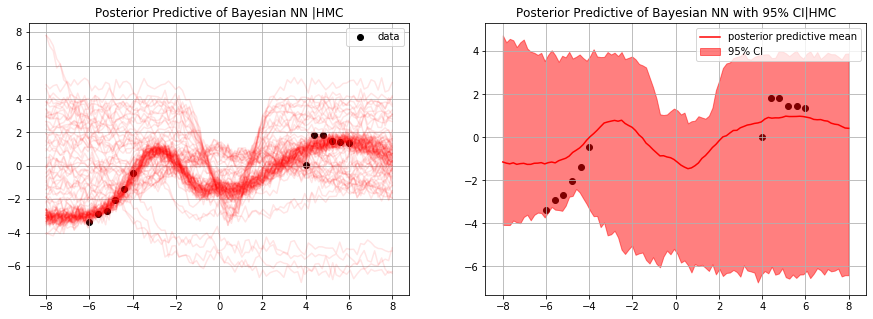

In [34]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

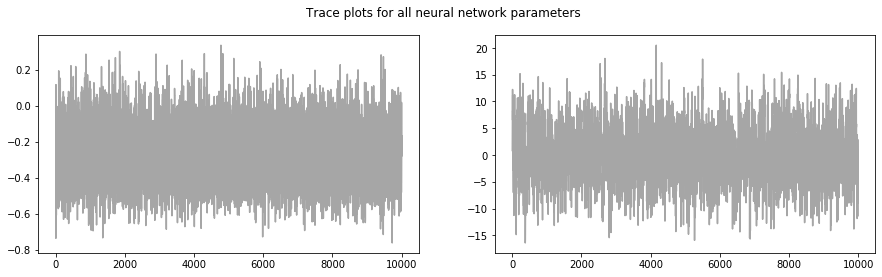

In [35]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

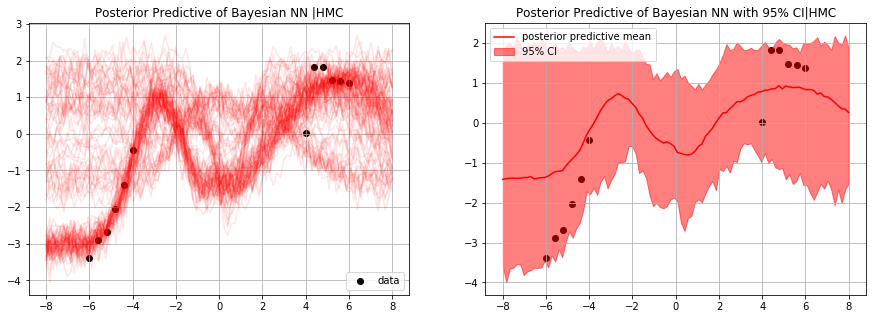

In [22]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

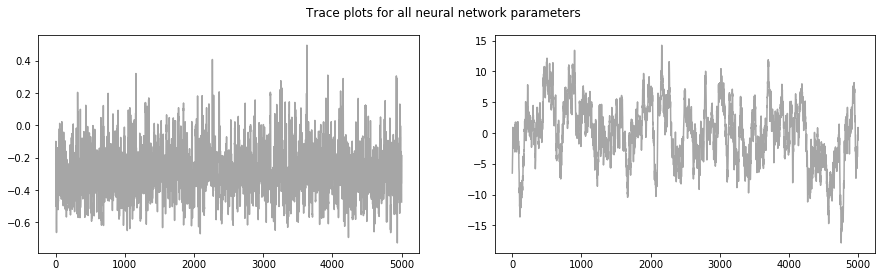

In [23]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

## Curve Subspace

In [36]:
width = 30
hidden_layers = 2
net = curve.BaseNet(1, width, hidden_layers)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

dataset = TensorDataset(torch.Tensor(x.reshape(-1, 1)), torch.Tensor(y))
loader = DataLoader(dataset, batch_size=64, shuffle = True)

# for training the two endpoints
params_base = {'epochs': 500}

NameError: name 'curve' is not defined

In [ ]:
def CurveNetGen(w0, w1):
    return curve.CurveNet(1, width, hidden_layers, w0, w1)

# for training the mid-points
params_curve = {'sample_size': 500}

In [ ]:
my_subspace = Subspace.create(subspace_type="curve", net = net, loader = loader, params_base = params_base, 
                           optimizer = optimizer, criterion = criterion, 
                           curve_net_gen = CurveNetGen, params_curve = params_curve)

In [ ]:
# change callback to control printing frequency (0 = no printing)
my_subspace.collect_vector(epochs = 100, callback = 20)
P, w = my_subspace.get_space()